In [61]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pypulseq as pp
import matplotlib.pyplot as plt

from diff_epi_tools import make_diff_epirs, plot_trajectory

import sys
sys.path.append("/Users/arielhannum/Documents/GitHub/gropt/python")
import gropt

sys.path.append("../")
from gropt_waveforms import *
from trap_waveforms_pulseq import *
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
max_slew_diffusion = 178 #178 or 43
pns_thresh = 0.95
max_grad = 38 # 38 or 200
mode = 'Brain'
ii = 3
waveform  = 'T' # T = Trap or G = Gropt
system = pp.Opts()

In [63]:
heart_bval = [250,500,750,1000]
liver_bval = [250,500,750,1000]
brain_bval = [250,500,750,1000]

Brain = {'Nx':80,
        'Ny':80,
        'fovx': 200e-3, 
        'fovy': 200e-3, 
        'partial_fourier': 6/8, 
        'slice_thickness': 6e-3,
        'b': brain_bval[ii],
        'MMT':0,
}

Liver = {'Nx':80,
        'Ny':80,
        'fovx': 200e-3, 
        'fovy': 200e-3, 
        'partial_fourier':  6/8, 
        'slice_thickness': 6e-3,
        'b':liver_bval[ii],
        'MMT':1,
}

Heart = {'Nx':80,
        'Ny':80,
        'fovx': 200e-3, 
        'fovy': 200e-3, 
        'partial_fourier':  6/8, 
        'slice_thickness': 6e-3,
        'b':heart_bval[ii],
        'MMT':2,
}

if pns_thresh == None:
    folder = 'Exp-1'
elif pns_thresh == 0.95 and max_slew_diffusion == 178:
    folder = 'Exp-2.5'
elif pns_thresh == 0.95 and max_slew_diffusion == 43:
    folder = 'Exp-3'

if max_grad == 200:
    scanner = 'High'
elif max_grad == 38:
    scanner = 'Conv'

if mode =='Brain': 
    input_args = Brain
if mode =='Liver': 
    input_args = Liver
if mode =='Heart': 
    input_args = Heart
    
input_args['pns_thresh'] = pns_thresh

savename = os.path.join('Sequences-phantom-2',folder, scanner,mode + '_2.5_' + waveform + '_b'+str(input_args['b'])+'_pns'+str(input_args['pns_thresh'])+'_s'+str(max_slew_diffusion))
if not os.path.exists(os.path.join('Sequences-phantom-2',folder, scanner)):
    os.makedirs(os.path.join('Sequences-phantom-2',folder, scanner))

matsave = os.path.join('Waveforms-phantom-2',folder, scanner,mode + '_2.5_' + waveform + '_b'+str(input_args['b'])+'_pns'+str(input_args['pns_thresh'])+'_s'+str(max_slew_diffusion))
if not os.path.exists(os.path.join('Waveforms-phantom-2',folder, scanner)):
    os.makedirs(os.path.join('Waveforms-phantom-2',folder, scanner))



In [66]:
# Put common arguments for the epi function here, because we call it twice and want to make sure our calls are consistent
epi_kwargs = {'Nx':input_args['Nx'],
              'Ny':input_args['Ny'],
              'fovx': input_args['fovx'], 
              'fovy': input_args['fovy'], 
              'partial_fourier':  input_args['partial_fourier'], 
              'R': 1.0,
              'slice_thickness': input_args['slice_thickness'],
              'Navg':5,
              'delay_TR': 3,  # just for better plotting in this demo, default is 3 (s)
              'seq_filename': savename + '.seq',
              'gmax_full':max_grad,
              'seq_filename': savename + ".seq", 
              'smax_full': 178,
              'do_fatsat':  True,
              'pe_enable': False,
              'seq_filename': "diff_calib_temp.seq", 
              'write_seq':  True,
            }

print(epi_kwargs)
_, timings = make_diff_epirs(**epi_kwargs, timings_only=False, )  # "timings_only=True" stops building the seq after figuring out timings

# timings is a dict with the three important timings, and delay_T1, delay_T2
print(f"{timings.keys() = }")
print(f"{1e3 * timings['t_90'] = :.2f}")
print(f"{1e3 * timings['t_180'] = :.2f}")
print(f"{1e3 * timings['t_readout'] = :.2f}")


{'Nx': 80, 'Ny': 80, 'fovx': 0.2, 'fovy': 0.2, 'partial_fourier': 0.75, 'R': 1.0, 'slice_thickness': 0.006, 'Navg': 5, 'delay_TR': 3, 'seq_filename': 'diff_calib_temp.seq', 'gmax_full': 38, 'smax_full': 178, 'do_fatsat': True, 'pe_enable': False, 'write_seq': True}
blip_duration 8e-05
kx_width 400.0
kx_width = 400.00
extra_area = 8.17
1000*pp.calc_duration(gx_fastest) = 0.58
1000*readout_time = 0.60
1000*(readout_time + blip_duration) = 0.68
1000*pp.calc_duration(gx) = 0.68
0.00068
BANDWIDTH 1984.126984126984
Timing check passed successfully
timings.keys() = dict_keys(['t_90', 't_180', 't_readout', 'delay_TE1', 'delay_TE2'])
1e3 * timings['t_90'] = 1.59
1e3 * timings['t_180'] = 3.92
1e3 * timings['t_readout'] = 20.46


In [53]:
0.00068*1e3

0.68

In [54]:
# Here we initialize designing the gradient whether it is a TRAP or GROPT Waveform 
params = {
        'gmax':max_grad, #mT/m --> Lower this a little to like 38
        'smax':max_slew_diffusion, #T/m/ms --> Lower this a little to like 190
        'T_readout':  timings['t_readout'] * 1e3, #ms
        'T_90': timings['t_90']*1e3, #ms
        'T_180': timings['t_180'] * 1e3, #ms
        'mode' : 'diff_bval',
        'MMT' : input_args['MMT'], # either [0, 1, 2] depending on level of motion compensation
        'b': input_args['b'], # s/mm2,
    }
    
if mode == 'Heart' and params['b'] == 500:
        params['gmax']-=2
if mode == 'Heart' and params['b'] == 750:
        params['gmax']-=2
if mode == 'Heart' and params['b'] == 1000:
        params['gmax']-=4
if mode == 'Liver' and params['b'] == 1000:
        params['gmax']-=2

if pns_thresh is not None:
        params['pns_thresh'] = pns_thresh

if waveform =='T': #We do TRAPS 
    params['dt'] =1e-5 # system.grad_raster_time
    params['gmax'] -=1

    if pns_thresh == None:
            params['pns_thresh'] = 3
            pns_thresh = 3

    if max_slew_diffusion > 100:
        params['smax'] = 100
    start_bval = params['b']
    gradient,Time,T_start,start_bval,p,= calc_trap(params.copy(),0.005,pns_thresh)
    params['TE']  = T_start
    print('TE = {:.2f}'.format(T_start))

elif waveform == 'G':
    params['dt'] = 3e-5
    gradient,Time,T_start,start_bval,p,= calc_trap(params.copy(),0.01,2)
    params['dt'] = 8e-5
    
    params2, gradient, te_track, b_track= calc_grop_hybrid(params.copy(), start_bval, T_start, 0.01, iterations=60)
    params = params2.copy()
print('TE = {:.2f} ms'.format(params['TE']))

	PNS is 0.91
TE = 80.31
TE = 80.31 ms


Bval = 995.47s/mm2
blip_duration 8e-05
kx_width 400.0
kx_width = 400.00
extra_area = 8.17
1000*pp.calc_duration(gx_fastest) = 0.58
1000*readout_time = 0.60
1000*(readout_time + blip_duration) = 0.68
1000*pp.calc_duration(gx) = 0.68
0.00068
-3
Segment lengths 159 3861 4250 6021
3702 3664.0000000000005
1738 1770.9999999999998


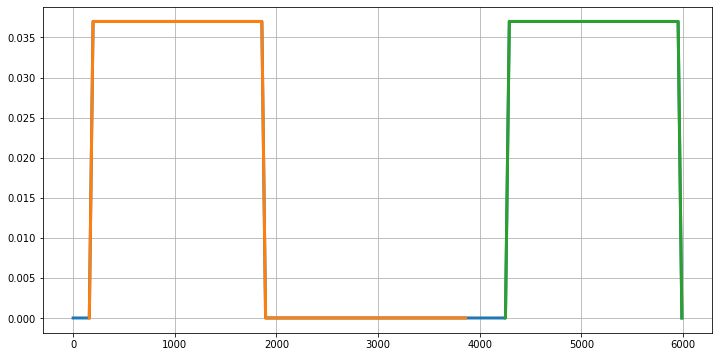

In [55]:
# Recompute G for gropt so it is the raster timing 
if waveform == 'T':
    epi_kwargs['TE'] = T_start*1e-3
    params['dt_out'] = system.grad_raster_time
    bval_params=params.copy()
    test = get_bval(gradient,bval_params)
    print('Bval = {:.2f}s/mm2'.format(test))

    
if waveform == 'G':
    params['dt_out'] = system.grad_raster_time
    gradient,_ = gropt.gropt(params.copy())
    bval_params=params.copy()
    bval_params['dt'] = system.grad_raster_time
    test = get_bval(gradient,bval_params)
    print('Bval = {:.2f}s/mm2'.format(test))
    epi_kwargs['TE'] = params['TE']*1e-3

# Recompute Timings for Our TE
G= np.squeeze(gradient)
_, timings = make_diff_epirs(**epi_kwargs, timings_only=True)  # "timings_only=True" stops building the seq after figuring out timings

adj_factor = 0
adj_factor1 = 0

if waveform == 'G':
    adj_factor = -5
if waveform == 'T':
    adj_factor = -3
    adj_factor1 = 38

print(adj_factor)
seg1_start = int(params['T_90']/params['dt_out']/1e3)
seg1_stop = int(seg1_start + timings['delay_TE1']/params['dt_out']) + adj_factor1

seg2_start = int(seg1_stop + params['T_180']/params['dt_out']/1e3)+adj_factor
seg2_stop = int(seg2_start + timings['delay_TE2']/params['dt_out'])#-adj_factor

print('Segment lengths',seg1_start, seg1_stop, seg2_start, seg2_stop,)

diff_grad1 = G[seg1_start:seg1_stop]
diff_grad2 = G[seg2_start:seg2_stop]

print(diff_grad1.size, timings['delay_TE1']/10e-6)
print(diff_grad2.size, timings['delay_TE2']/10e-6)

time = np.linspace(0,len(G),len(G))
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(time,G,linewidth =3 )
plt.plot(time[seg1_start:seg1_stop],diff_grad1,linewidth =3 )
plt.plot(time[seg2_start:seg2_stop],diff_grad2,linewidth =3 )
plt.show()

In [56]:
# Either save the seq object after this call, or use arguments: seq_filename = "<savename>.seq" and write_seq = True
seq, timings = make_diff_epirs(diff_grad1 = diff_grad1, diff_grad2 = diff_grad2,write_seq=True,
                                 **epi_kwargs,)

blip_duration 8e-05
kx_width 400.0
kx_width = 400.00
extra_area = 8.17
1000*pp.calc_duration(gx_fastest) = 0.58
1000*readout_time = 0.60
1000*(readout_time + blip_duration) = 0.68
1000*pp.calc_duration(gx) = 0.68
0.00068
BANDWIDTH 1984.126984126984
Timing check passed successfully


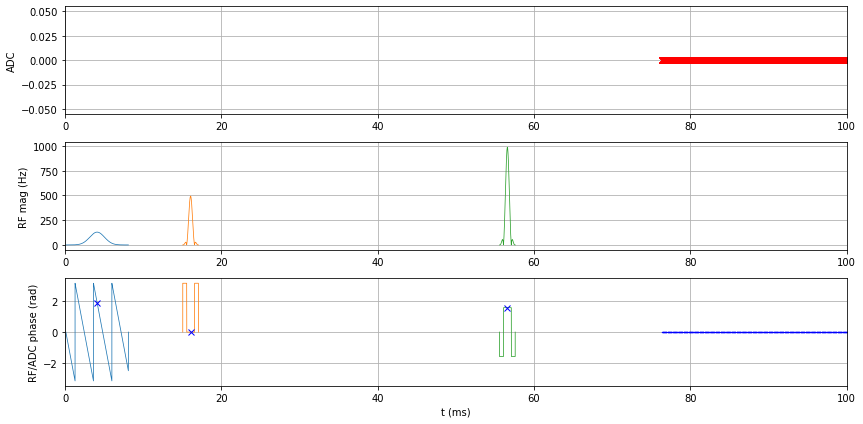

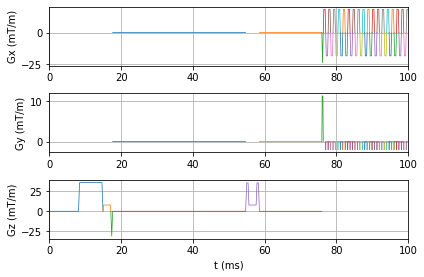

In [57]:
plt.figure(figsize=(12,6))
seq.plot(time_disp = 'ms', grad_disp='mT/m',time_range=(0,0.1))
# plot_trajectory(seq)  # This is messed up right now for more than 1 TR 

In [58]:
from scipy.io import savemat
save_params = params.copy()
save_params['TE'] = epi_kwargs['TE']*1e3
save_params['Grad'] = G
save_params['Time'] = time

savemat(matsave + '.mat',save_params)

In [59]:
save_params['TE']

80.31499999999912

In [60]:
start_bval

995.4747153117131